In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid
from pyextal.dinfo import CBEDDiffractionInfo
from pyextal.roi import CBEDROI
from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2, Chi2_const



pyextal package imported. Version: 0.0.1


In [2]:
plt.rcParams['image.cmap'] = 'inferno'

# load data
1. load the input data
2. load the mtf for the detector
3. display the data

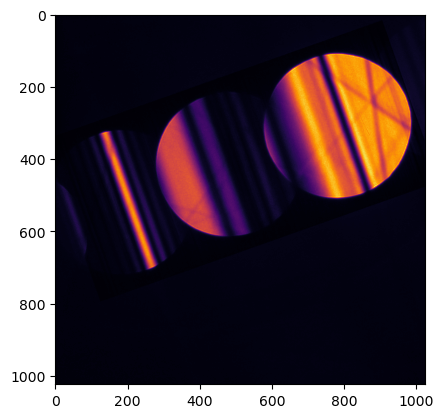

In [3]:
data = np.fromfile("../box/z200n.img", dtype=np.int16, offset=8).reshape(-1, 1024,1024)
dp = data[0]
mtf = np.load('../box/YAG 120 CCD MTF.npy')

plt.imshow(dp)

# set detector parameters
- set the detector parameters, check [Electron Detection Characteristics of a Slow-Scan CCD Camera, Imaging Plates and Film, and Electron Image Restoration](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/) for what the parameters mean
   - varB
   - delta
   - A
   - g
   - m
- background for Lucy-Richardson deconvolution (currently no use)


In [4]:
dtpar = [16.868, 4.1797e-5, 1.1108, 1.047, 0.07229]
background = 38.0681229


# initialize diffraction info class
- stores dp
- stores mtf
- stores detector parameters
- stores strcuture factor
- stores calibration (gl)
- stores incident beam tilt (estimated)
- stores sample thickness (estimated)
- stores .dat files describing the crystal

In [5]:
dinfo = CBEDDiffractionInfo(dp, 775.9,  0.3, 0, 158.708, 'example/Cu2O/Cu2O.dat', dtpar, mtf, background,)

# region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- nthgx: which hkl relative to the xaxis set in .dat
- dpCenter: of diffraction pattern for simulation as reference point
- dpSize: size of the diffraction pattern for simulation

In [6]:
rotation = -19.44
dpCenter = [250, 950]
dpSize = [500,1200]

- gx: the horizontal axis for simulation

In [7]:
roi = CBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([1,0,0]), gInclude=[(0,0,0),(-2,0,0),(-4,0,0)], dpCenter=dpCenter, dpSize=dpSize) 

(-1, 0, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0.0, 0.0, array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32))
 open file failed


ValueError: error parsing the .dat file

select the region of interest for refinement
- regions: define 3 points relative to dpCenter to defeine a parallelogram, multiple regions can be defined, [[region1_top_left, region1_top_right, region1_bottom_left, pixels],  
 [region2_top_left, region2_top_right, region2_bottom_left], ...]  
region_top_left = [row, column]  
pixels = [pixels_row, pixels_column]

- mask: whether to include the region for each reflection selected in nthgx [[region1_beam1, region1_beam2, ...], [region2_beam1, region2_beam2, ...], ...], 1 include, 0 exclude

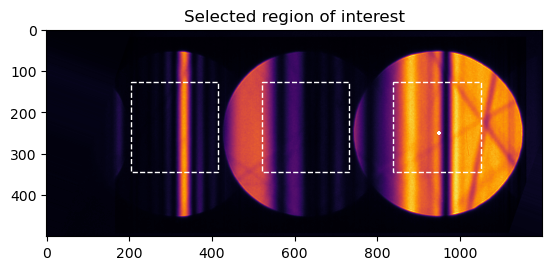

In [8]:
roi.selectROI(np.array([[[-123,-111], [-123, 100], [93,-111], [46,12]]]))
roi.displayROI()

# initialize coarse refine
- need to define a seperate .dat file for bigger convergence angle i.e. bigger region in reciprocal space

- only support rectangular ROI, and only one region

In [9]:
print(dinfo.tiltX, dinfo.tiltY)

0.3 0


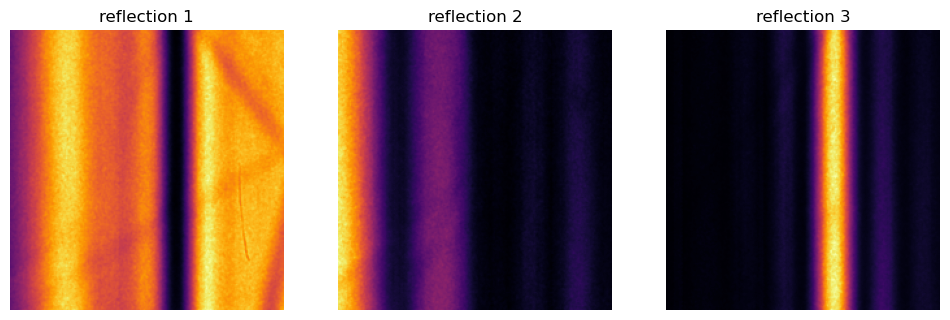

In [10]:
coarse = CoarseOptimize(datpath='Cu2O/Cu2O_LARBED.dat', dinfo=dinfo, roi=roi)

In [11]:
coarse.optimizeOrientationThickness()



Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 783.7357932443356, gl: 158.708, tiltY: 0.05228596648470751, tiltX: 0.31837074498111345


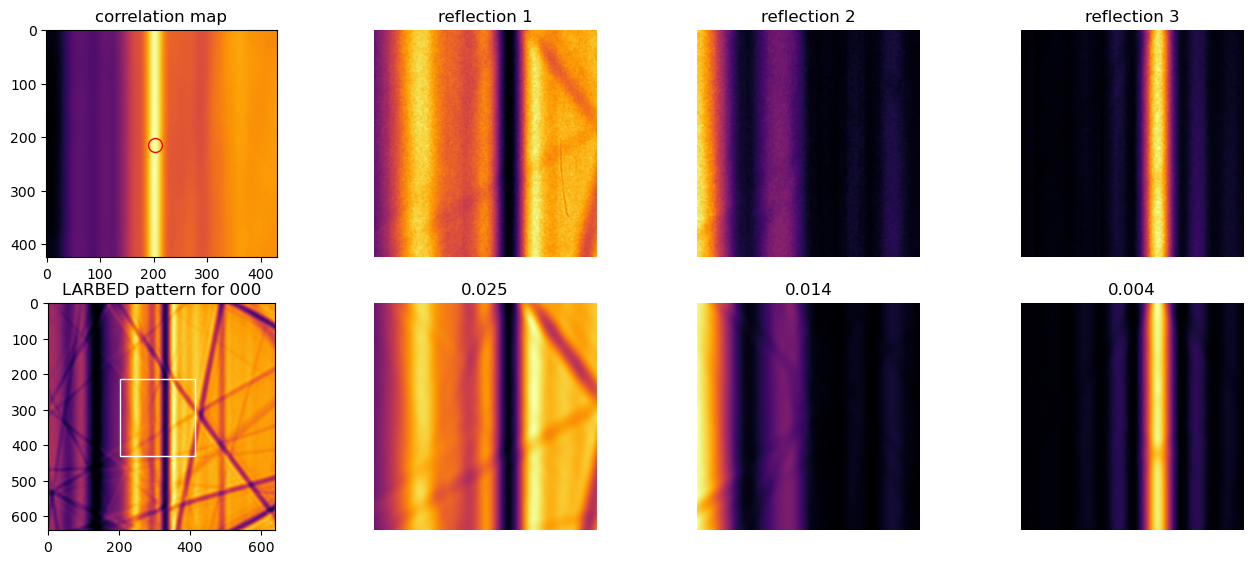

In [12]:
coarse.displayCoarseSearch()

In [9]:
roi.setTilt0(np.array([2.59327,-8.68843,4.34422]), np.array([251,883]))

[ 530.57028232 1089.59733157]


In [11]:
roi.transformDP(roi.kt2pixel(np.array([2.59327,-8.68843,4.34422]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter)

array([[250.99999876, 882.99999808]])

In [10]:
res = roi.kt2pixel(np.array([[1.1634984, -8.8558645, 4.4278831], 
                             [2.5114207, -8.8576450, 4.4288225],
                             [1.3609641, -8.8013630, 4.4006815],
                             [2.2644966, -8.9513435, 4.4756718],
                             [1.1409886, -8.6881647, 4.3440342],
                             [1.5137377, -8.9152498, 4.4575748],
                             [ 2.0595229, -8.7067947, 4.3533487],
                             [1.9047260, -8.8679590, 4.4339304],
                             ]))
points = [155,101,50,40]
for endpoints, p in zip(res.reshape(-1, 2, 2), points):
    print(f'[[{endpoints[0][0]:.5f}, {endpoints[0][1]:.5f}], [{endpoints[1][0]:.5f}, {endpoints[1][1]:.5f}], [{endpoints[0][0]:.5f}, {endpoints[0][1]:.5f}], [{p}, 1]], ')

[[11.27617, -114.31886], [11.59560, 99.60719], [11.27617, -114.31886], [155, 1]], 
[[1.60886, -82.97947], [28.22155, 60.41836], [1.60886, -82.97947], [101, 1]], 
[[-18.48057, -117.89134], [21.81349, -58.73308], [-18.48057, -117.89134], [50, 1]], 
[[-15.17488, 27.88740], [13.42224, 3.31989], [-15.17488, 27.88740], [40, 1]], 


In [10]:
roi.transformDP(roi.kt2pixel(np.array([2.59327,-8.68843,4.34422]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter)

array([[250.99999876, 882.99999808]])

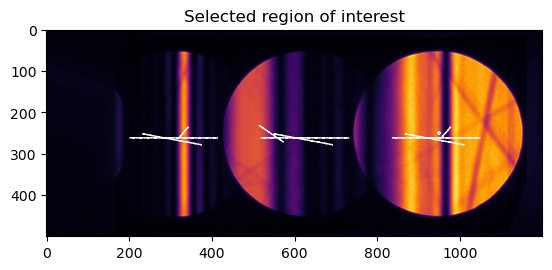

In [13]:
roi.selectROI(np.array([
[[11.27617, -114.31886], [11.59560, 99.60719], [11.27617, -114.31886], [155, 1]], 
[[1.60886, -82.97947], [28.22155, 60.41836], [1.60886, -82.97947], [101, 1]], 
[[-18.48057, -117.89134], [21.81349, -58.73308], [-18.48057, -117.89134], [50, 1]], 
[[-15.17488, 27.88740], [13.42224, 3.31989], [-15.17488, 27.88740], [40, 1]], 
                       ]),
                       mask=np.array([[1,1,1],[1,1,1],[0,1,0],[1,0,1]])
                      )
# roi.selectROI(np.array([[[-23.73,-111.92], [-23.41, 101.99], [-23.73,-111.92], [155,1]],
#                         [[-33.41, -80.58], [-6.79, 62.81], [-33.41, -80.58], [101,1]],
#                         [[-53.49, -115.49],[-13.20, -56.33],[-53.49, -115.49], [50, 1]],
#                         [[-50.19, 30.28],  [-21.59, 5.72], [-50.19, 30.28], [40,1]]
#                         ]), mask=np.array([[1,1,1],[1,1,1],[1,1,0],[1,0,1]]))
roi.displayROI()

In [14]:
roi.simGrid

array([[ 1.1634984 , -8.85584283,  4.42792641],
       [ 1.17225114, -8.85585452,  4.42793226],
       [ 1.18100388, -8.85586621,  4.4279381 ],
       ...,
       [ 1.91266431, -8.85967256,  4.42984128],
       [ 1.90869515, -8.86380497,  4.43190749],
       [ 1.904726  , -8.86793739,  4.43397369]])

# initialize fine refine for structure factor
- reflections: list of reflections to refine
- errorFunc: error function to use for refinement, define in gof.py, if developing new error function, inherit from BaseGOF ABC.
- perturbROI: allow shift or rotation or scale of the region of interest
- shift disk: allow region of interest to shift different for each beam selected by nthgx

In [14]:
fine = FineOptimize(dinfo=dinfo,
                    roi=roi,
                    reflections=[(2,0,0),(4,0,0)],
                    sfMask=np.array([[True, True], [True, True]]),
                    errorFunc=Chi2_const(dinfo),
                    perturbROI=True,
                    shiftDisk=False)

# fine.getx0()

In [18]:
from callBloch import lookupSF
lookupSF([(2,0,0), (4,0,0)])

array([[4.4759151e-02, 0.0000000e+00, 3.3385975e-03, 1.8000000e+02],
       [3.2641590e-02, 0.0000000e+00, 2.8728601e-03, 1.8000000e+02]],
      dtype=float32)

In [15]:
extal = np.array([[0.05, 0, 0.373561E-02, 180], 
                  [0.3E-01, 0, 0.267839E-02, 180],])
fine.getx0(extal[:,::2])
fine.getRange(np.array([[[0.048, 0.0035], [0.0325,0.0023]], [[0.0482, 0.004],[0.033, 0.0026]]]))

setting the initial value and normalization range to:
beam: (2, 0, 0)
      lower       value       upper  
U : 4.8000000e-02   5.0000000e-02   4.8200000e-02
UA: 3.5000000e-03   3.7356100e-03   4.0000000e-03
------------------------------
beam: (4, 0, 0)
      lower       value       upper  
U : 3.2500000e-02   3.0000000e-02   3.3000000e-02
UA: 2.3000000e-03   2.6783900e-03   2.6000000e-03
------------------------------


(2, 0, 0): U 0.0500000 UA 0.0037356
(4, 0, 0): U 0.0300000 UA 0.0026784
Chi Square single background: 4.63345


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


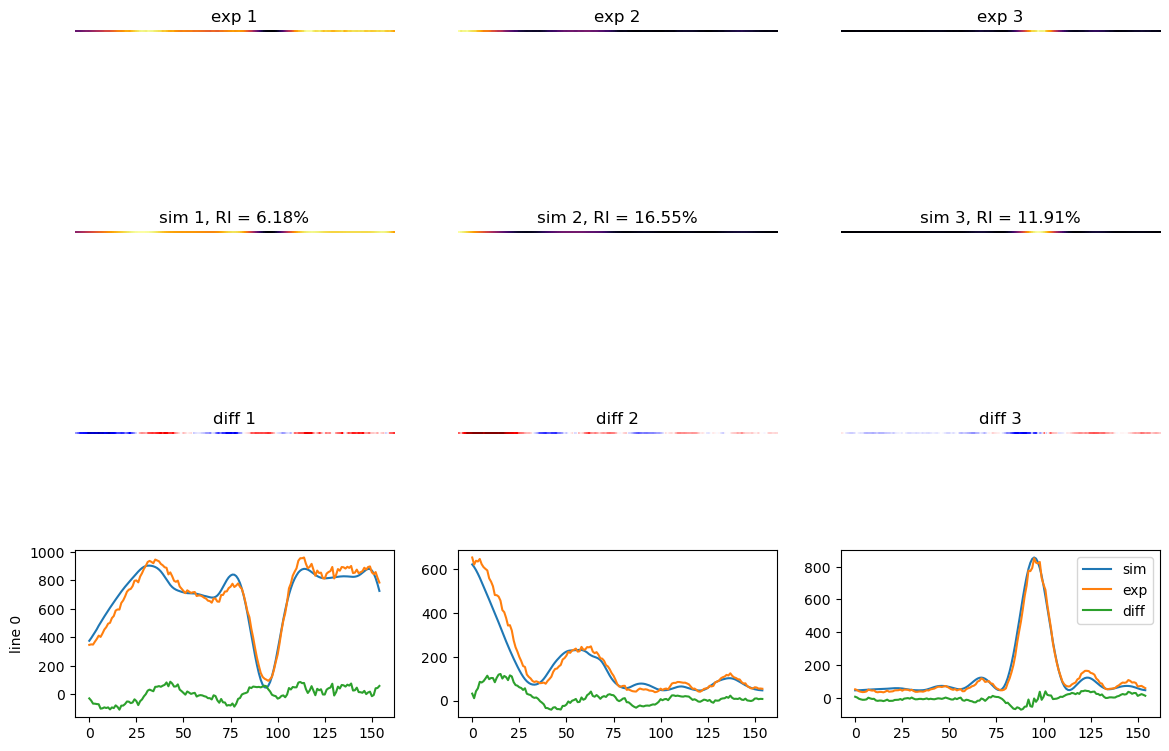

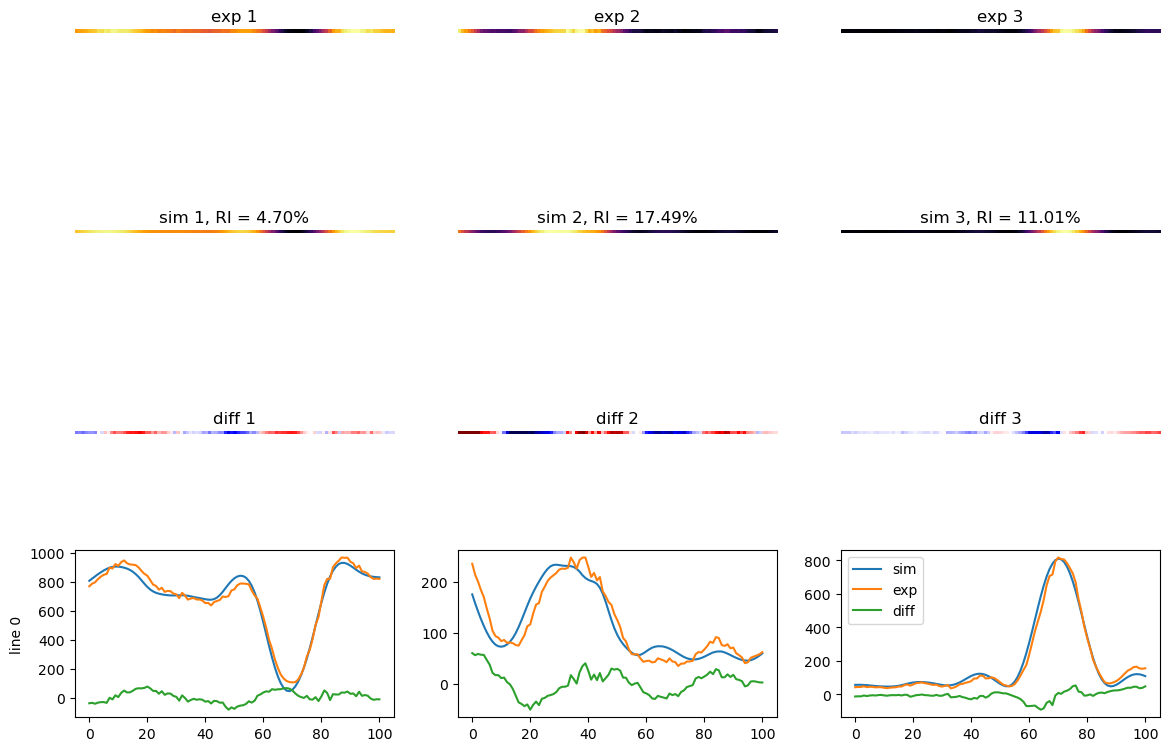

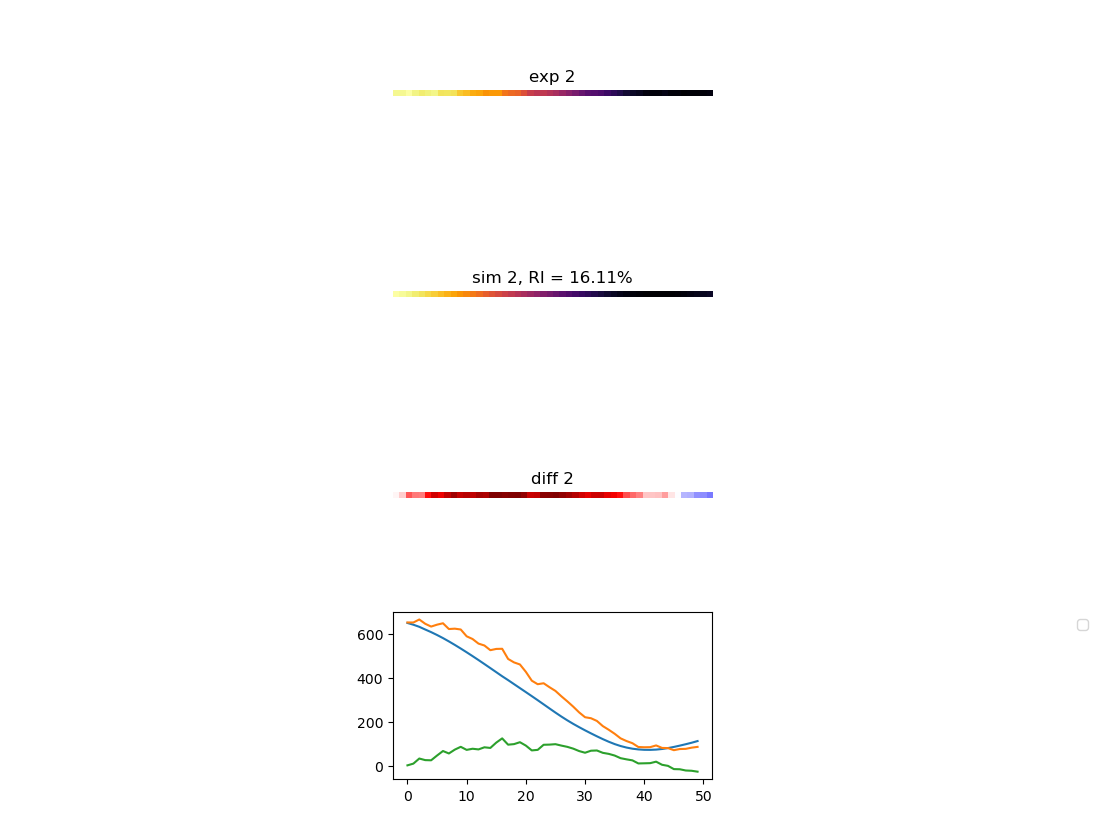

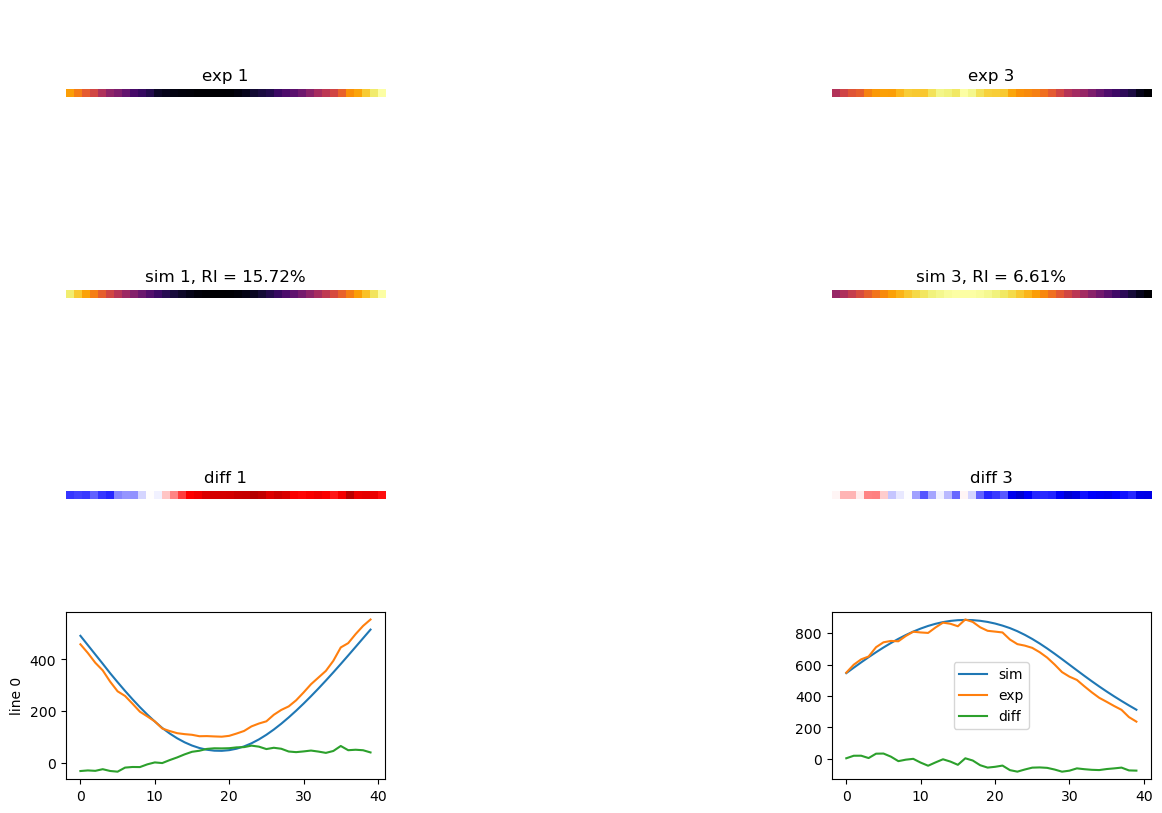

In [16]:
fine.display([0,])

start the refinement
- x0: initial guess for the structure factor, if not provided, use the structure factor save in fine (1,1,1,1) (bird's atomic scatter factor) if no previous fine refinement

In [17]:
%matplotlib qt
fine.optimize()
# fine.optimize()

setting the initial value and normalization range to:
beam: (2, 0, 0)
      lower       value       upper  
U : 4.8000000e-02   5.0000000e-02   4.8200000e-02
UA: 3.5000000e-03   3.7356100e-03   4.0000000e-03
------------------------------
beam: (4, 0, 0)
      lower       value       upper  
U : 3.2500000e-02   3.0000000e-02   3.3000000e-02
UA: 2.3000000e-03   2.6783900e-03   2.6000000e-03
------------------------------


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


start optimization
normal:[[0.05       0.00373561]
 [0.03       0.00267839]]
SF:
(2, 0, 0): 5.0000000e-02 3.7356100e-03
(4, 0, 0): 3.0000000e-02 2.6783900e-03
thickness: 771.67 gl: 158.60354 rotation: -19.35879
corner: -1.87704 -0.55035
GOF: 2.81813  func eval: 202
Error: 2.7936934101788293  func eval: 202
********************
SF:
(2, 0, 0): 5.0100000e-02 3.7356100e-03
(4, 0, 0): 3.0000000e-02 2.6783900e-03
thickness: 770.96 gl: 158.60087 rotation: -19.35892
corner: -1.87846 -0.55751
GOF: 2.86777  func eval: 80
Error: 2.8429004470736996  func eval: 80
********************
SF:
(2, 0, 0): 5.0000000e-02 3.7473905e-03
(4, 0, 0): 3.0000000e-02 2.6783900e-03
thickness: 771.66 gl: 158.60244 rotation: -19.35863
corner: -1.87652 -0.55732
GOF: 2.82162  func eval: 121
Error: 2.797159125120424  func eval: 121
********************
SF:
(2, 0, 0): 5.0000000e-02 3.7356100e-03
(4, 0, 0): 2.9875000e-02 2.6783900e-03
thickness: 771.65 gl: 158.60208 rotation: -19.35853
corner: -1.88111 -0.55916
GOF: 2.814

# display the result
- lines: list of lines to display, each line is a row in the region of interest

(2, 0, 0): U 0.0475488 UA 0.0034753
(4, 0, 0): U 0.0318978 UA 0.0027045
Chi Square single background: 1.33851


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


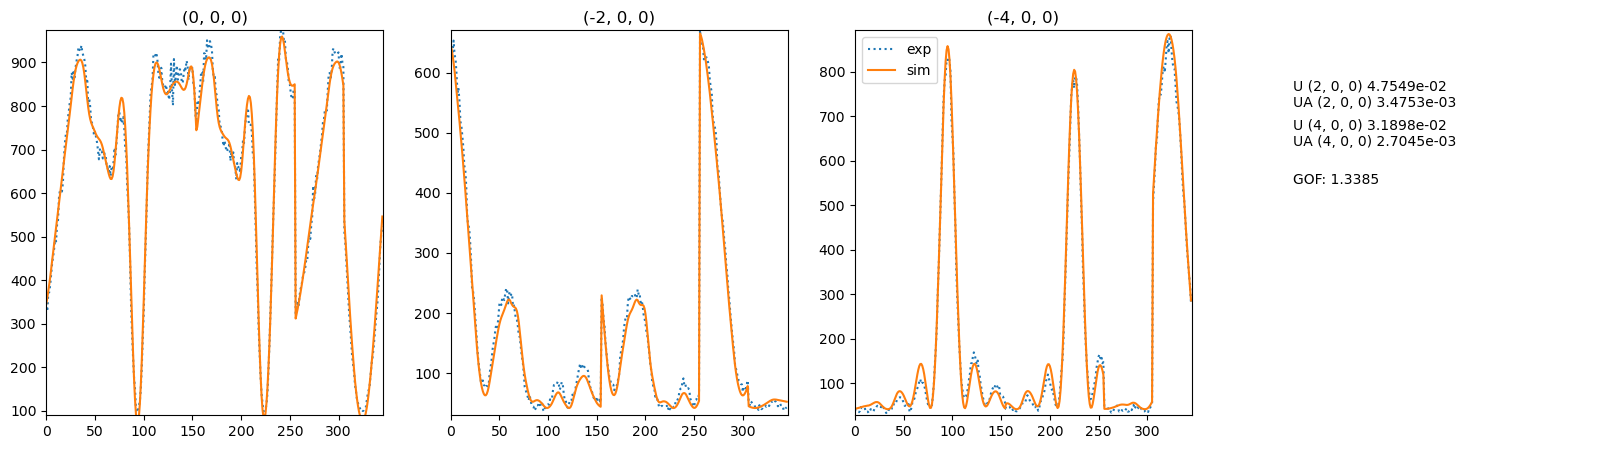

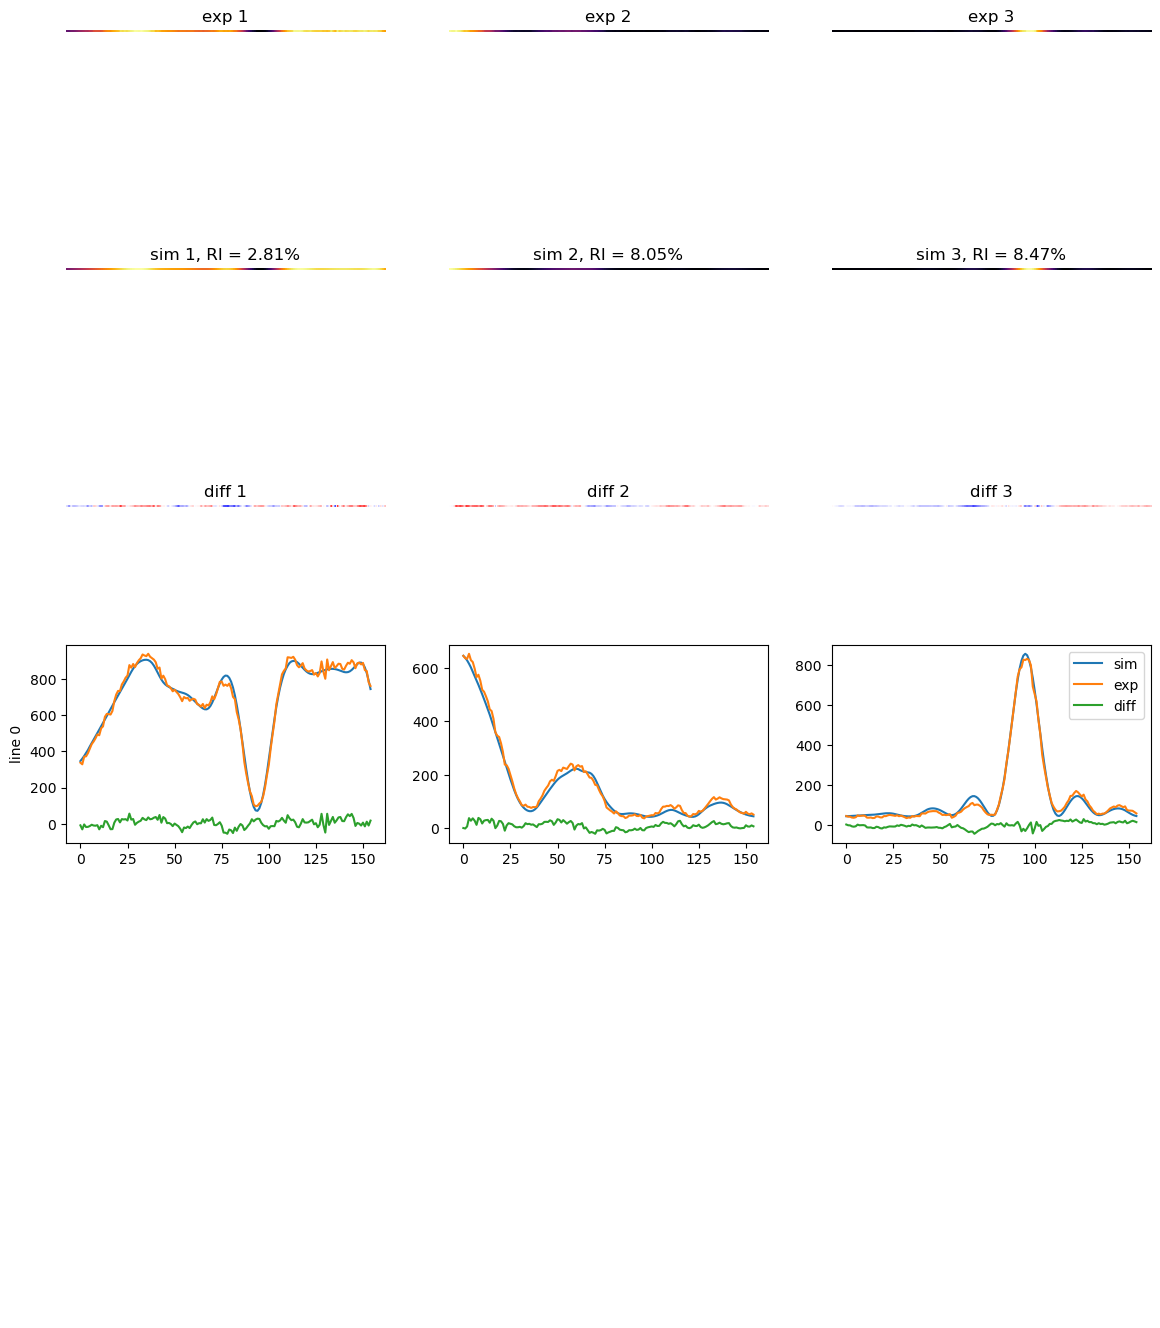

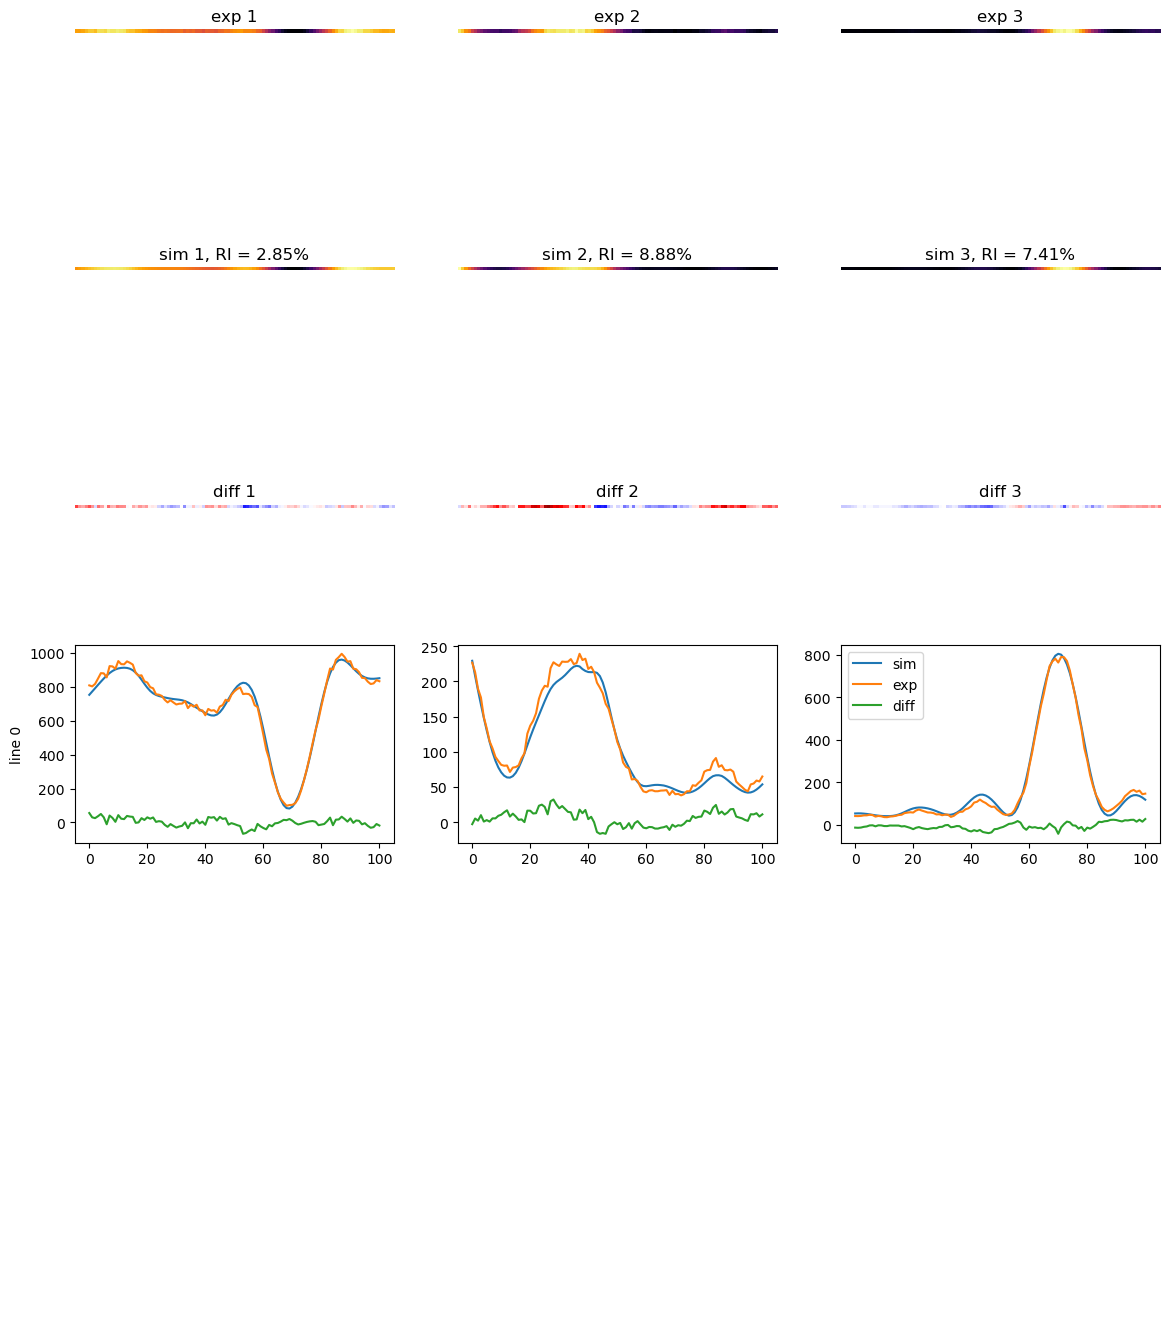

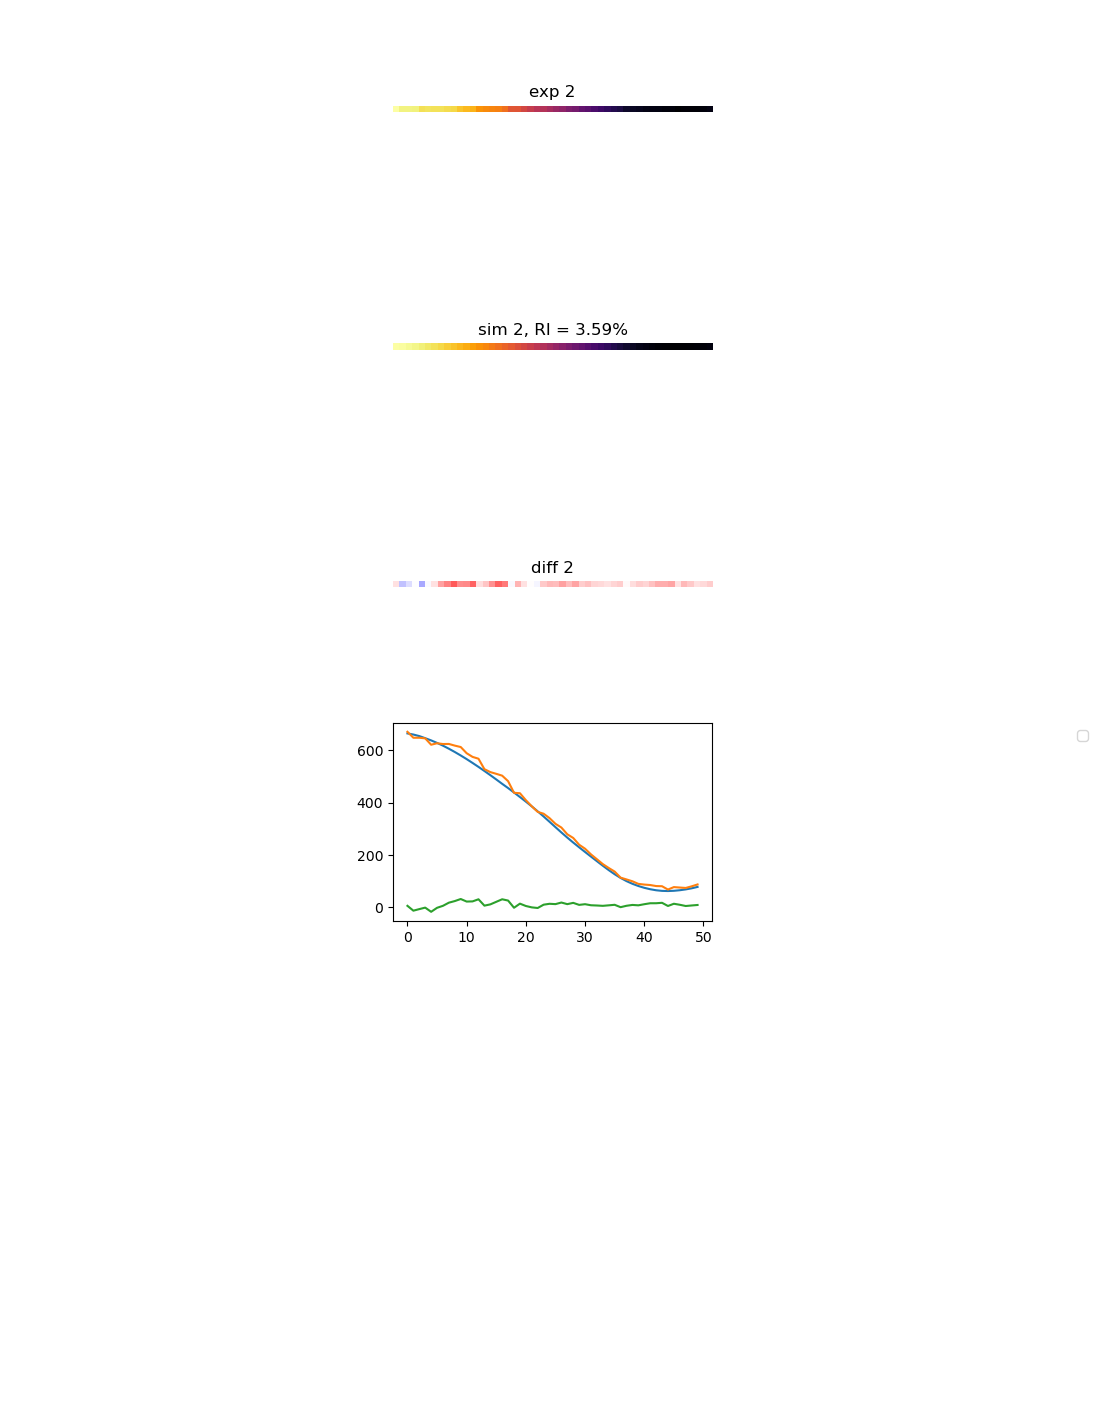

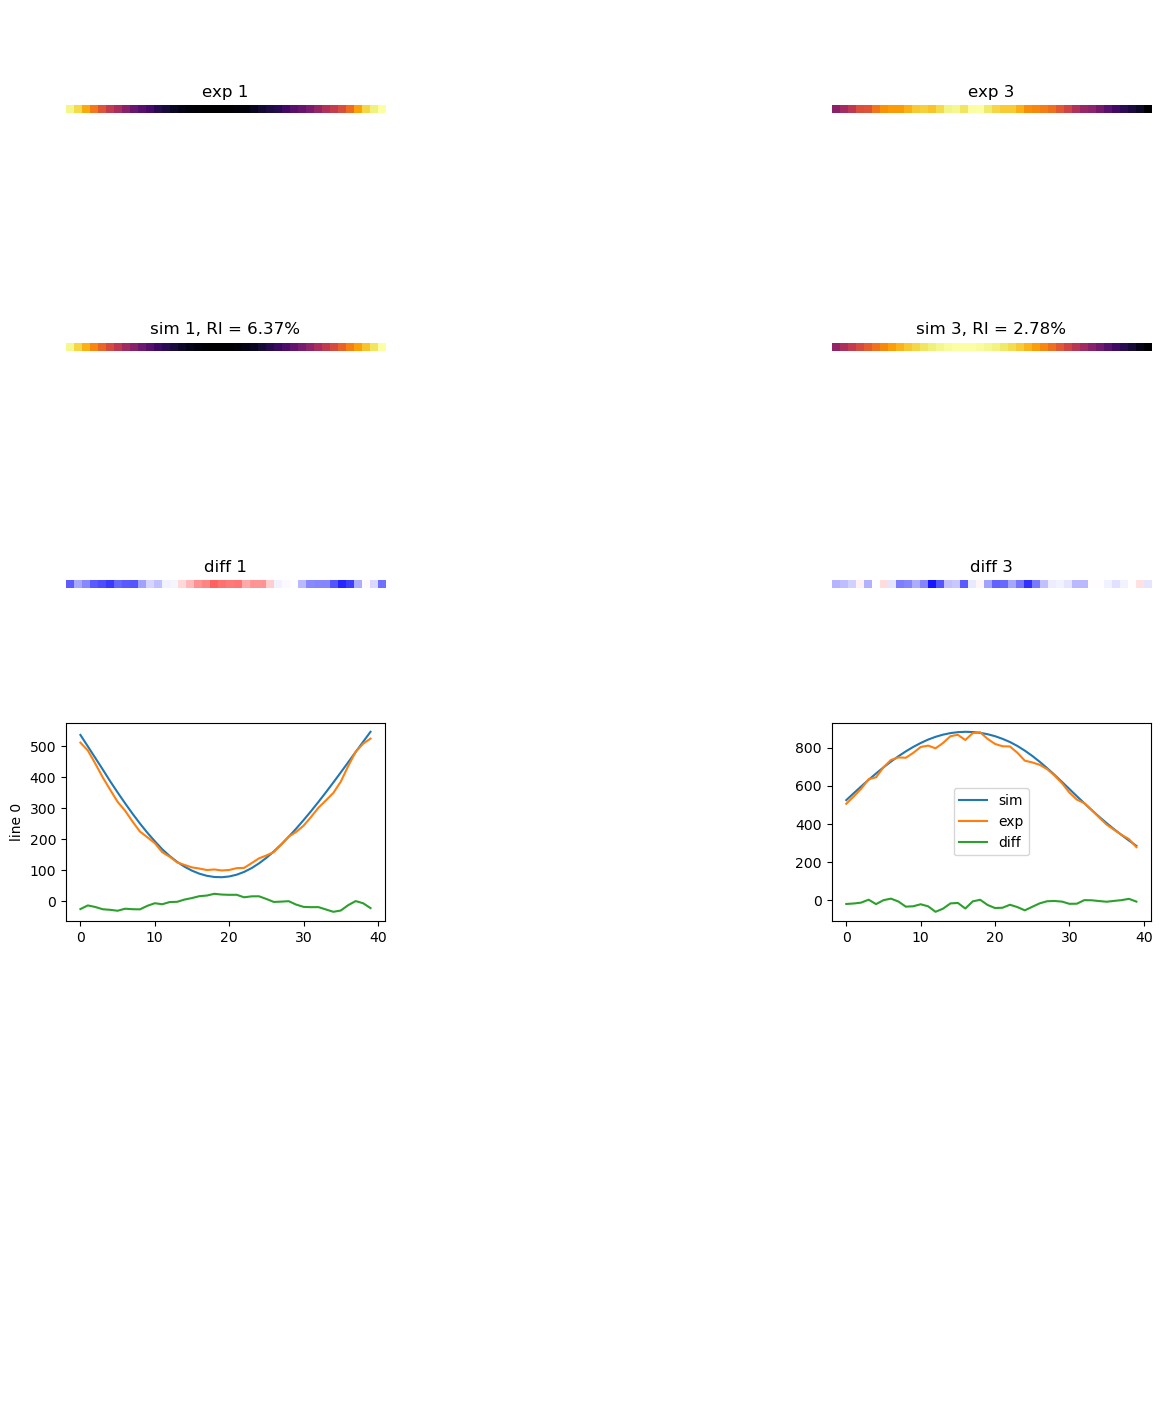

In [18]:
%matplotlib inline
fine.display([0,6,10])

In [19]:
print(f'kt: 2.59247 -8.66640  4.33320 = {roi.transformDP(roi.kt2pixel(np.array([[2.59247, -8.66640, 4.33320]]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter+roi.allshift)}')
print(f'gl: {roi.gl} rotation: {roi.rotation}')
print(f'thickness: {fine.thickness} ')
print(f'norm:: {fine.errorFunc.scale}')
print(f'background: {fine.errorFunc.background}')

kt: 2.59247 -8.66640  4.33320 = [[244.18536755 880.0753202 ]]
gl: 158.71392453007132 rotation: -19.59470032642472
thickness: 781.1314127968801 
norm:: 727.3183321467834
background: 41.748070095824126


In [20]:
from pyextal.callBloch import terminate
terminate()
